In [1]:
# 03_baselines_probabilistic.ipynb
# Baselines for travel time with probabilistic outputs

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

print("Loaded libraries.")


Loaded libraries.


In [2]:
# === Load processed data ===
df = pd.read_csv("data/processed/travel_features_rich.csv")

print("Shape:", df.shape)
print(df.head())


Shape: (1680498, 23)
   duration_min  hour  weekday  temp  feelslike   dew  humidity  precip  \
0      2.550000    17        2  11.3       11.3  -4.5     32.74     0.0   
1     13.734617    23        4   8.3        5.6  -2.1     47.62     0.0   
2     11.842950    19        2  10.5       10.5  -4.2     35.46     0.0   
3      4.060483    12        3   2.5       -1.5 -12.9     30.97     0.0   
4     23.020733    10        5   4.1        0.4  -8.7     38.64     0.0   

   precipprob preciptype  ...  windspeed  winddir  sealevelpressure  \
0         0.0       none  ...       11.1    264.0            1023.5   
1         0.0       none  ...       17.4    272.0            1017.3   
2         0.0       none  ...        8.9    291.0            1024.7   
3         0.0       none  ...       16.6    233.0            1021.3   
4         0.0       none  ...       17.3    318.0            1025.3   

   cloudcover  visibility  solarradiation  solarenergy  uvindex  \
0        19.2        16.0         

In [3]:
# Feature definitions
numeric_weather = [
    "temp", "feelslike", "dew", "humidity", "precip", "precipprob",
    "snow", "snowdepth", "windgust", "windspeed", "winddir",
    "sealevelpressure", "cloudcover", "visibility", "solarradiation",
    "solarenergy", "uvindex"
]

cat_cols = ["preciptype", "conditions", "icon"]

base_cols = ["duration_min", "hour", "weekday"] + numeric_weather + cat_cols

df_model = df[base_cols].copy()

# Criar uma flag simples de chuva para o baseline histórico
df_model["is_rainy"] = (df_model["precip"] > 0) | (df_model["preciptype"].str.contains("rain", case=False))

print("df_model shape:", df_model.shape)


df_model shape: (1680498, 24)


In [4]:
# One-hot encoding das variáveis categóricas
df_ml = pd.get_dummies(df_model.drop(columns=["is_rainy"]), columns=cat_cols, drop_first=True)

print("df_ml shape:", df_ml.shape)

# Separar X e y
y = df_ml["duration_min"].values
X = df_ml.drop("duration_min", axis=1).values
feature_names = df_ml.drop("duration_min", axis=1).columns.tolist()

# Train / test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train size:", X_train.shape[0], " Test size:", X_test.shape[0])

# Scaling
x_scaler = StandardScaler()
X_train_scaled = x_scaler.fit_transform(X_train)
X_test_scaled  = x_scaler.transform(X_test)

print("Scaling done.")


df_ml shape: (1680498, 35)
Train size: 1344398  Test size: 336100
Scaling done.


[LinearRegression] Test MAE:  6.451
[LinearRegression] Test RMSE: 8.888
[LinearRegression] Estimated residual std (sigma): 8.924
[LinearRegression] 10-90% interval coverage: 89.9%


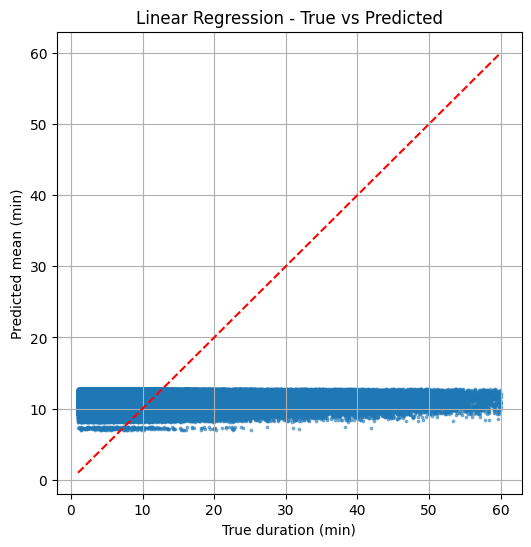

In [5]:
# === Baseline 1: Linear Regression + Gaussian residual distribution ===

linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)

y_train_pred = linreg.predict(X_train_scaled)
y_test_pred  = linreg.predict(X_test_scaled)

# Point metrics
mae_lr  = mean_absolute_error(y_test, y_test_pred)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"[LinearRegression] Test MAE:  {mae_lr:.3f}")
print(f"[LinearRegression] Test RMSE: {rmse_lr:.3f}")

# Estimated global residual std (sigma) from train
residuals = y_train - y_train_pred
sigma = residuals.std()
print(f"[LinearRegression] Estimated residual std (sigma): {sigma:.3f}")

# Normal quantile multipliers (approx) for 10/50/90%
z10 = -1.2816
z50 = 0.0
z90 = 1.2816

q10_lr = y_test_pred + z10 * sigma
q50_lr = y_test_pred + z50 * sigma
q90_lr = y_test_pred + z90 * sigma

# Coverage of 10-90% interval
inside_10_90 = ((y_test >= q10_lr) & (y_test <= q90_lr)).mean()
print(f"[LinearRegression] 10-90% interval coverage: {inside_10_90*100:.1f}%")

# Simple scatter: true vs mean prediction
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_pred, s=3, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True duration (min)")
plt.ylabel("Predicted mean (min)")
plt.title("Linear Regression - True vs Predicted")
plt.grid(True)
plt.show()


Hist baseline - train size: 1344398  test size: 336100
Building bucket_durations...


Building buckets: 100%|██████████| 1344398/1344398 [00:22<00:00, 61081.31it/s]


Total buckets (hour, weekday, is_rainy): 216
Building fallback buckets...


Building fallbacks: 100%|██████████| 1344398/1344398 [00:25<00:00, 52622.26it/s]


Generating predictions for test set...


Predicting: 100%|██████████| 336100/336100 [04:50<00:00, 1156.72it/s]




[HistBaseline] Test MAE (mean of bucket):  6.457
[HistBaseline] Test RMSE (mean of bucket): 8.895
[HistBaseline] 10-90% interval coverage:   80.0%


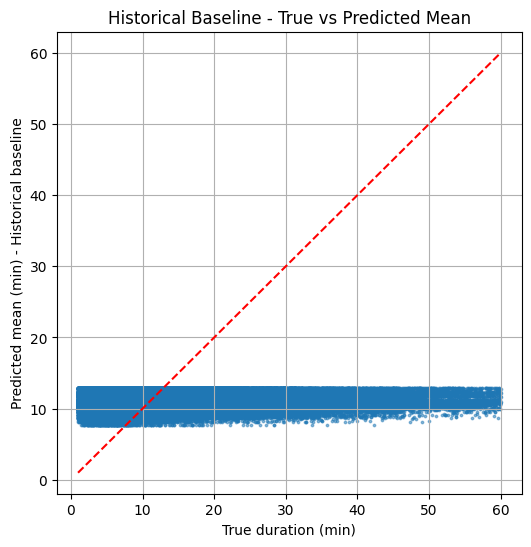

In [7]:
# === Baseline 2: Historical conditional distribution (hour, weekday, rainy_flag) ===

# Para esse baseline, vamos trabalhar no espaço original (sem one-hot/scaling),
# utilizando apenas o train split (usando o mesmo índice de split da ML).

# Recuperar df_model alinhado com X/Y
# Precisamos reconstruir um índice consistente. Mais fácil: refazer split no df_model.

from tqdm import tqdm

df_model_for_split = df_model.copy()
df_model_for_split["row_id"] = np.arange(len(df_model_for_split))

train_idx, test_idx = train_test_split(
    df_model_for_split["row_id"].values,
    test_size=0.2,
    random_state=42
)

train_mask = df_model_for_split["row_id"].isin(train_idx)
test_mask  = df_model_for_split["row_id"].isin(test_idx)

df_train_hist = df_model_for_split[train_mask].copy()
df_test_hist  = df_model_for_split[test_mask].copy()

print("Hist baseline - train size:", len(df_train_hist), " test size:", len(df_test_hist))

# Construir chave de contexto para buckets
def build_key(df_):
    # chave (hour, weekday, is_rainy)
    return list(zip(df_["hour"], df_["weekday"], df_["is_rainy"]))

df_train_hist["ctx_key"] = build_key(df_train_hist)
df_test_hist["ctx_key"]  = build_key(df_test_hist)

# Construir dicionário: ctx_key -> lista de durações de viagem
from collections import defaultdict

bucket_durations = defaultdict(list)
print("Building bucket_durations...")
for _, row in tqdm(df_train_hist.iterrows(), total=len(df_train_hist), desc="Building buckets"):
    bucket_durations[row["ctx_key"]].append(row["duration_min"])

print("Total buckets (hour, weekday, is_rainy):", len(bucket_durations))

# Também construir buckets mais agregados para fallback:
# (hour, weekday) e apenas hour
bucket_hw = defaultdict(list)
bucket_h  = defaultdict(list)
print("Building fallback buckets...")
for _, row in tqdm(df_train_hist.iterrows(), total=len(df_train_hist), desc="Building fallbacks"):
    key_hw = (row["hour"], row["weekday"])
    key_h  = row["hour"]
    bucket_hw[key_hw].append(row["duration_min"])
    bucket_h[key_h].append(row["duration_min"])

global_durations = df_train_hist["duration_min"].values

def get_bucket_samples(ctx_key, hour, weekday, min_size=30):
    # 1) tenta bucket completo (hour, weekday, is_rainy)
    samples = bucket_durations.get(ctx_key, [])
    if len(samples) >= min_size:
        return np.array(samples)
    # 2) fallback para (hour, weekday)
    samples = bucket_hw.get((hour, weekday), [])
    if len(samples) >= min_size:
        return np.array(samples)
    # 3) fallback para hour
    samples = bucket_h.get(hour, [])
    if len(samples) >= min_size:
        return np.array(samples)
    # 4) fallback global
    return global_durations

# Gerar quantis e previsão média para cada amostra de teste
q10_hist = []
q50_hist = []
q90_hist = []
mean_hist = []

print("Generating predictions for test set...")
for _, row in tqdm(df_test_hist.iterrows(), total=len(df_test_hist), desc="Predicting"):
    ctx_key = row["ctx_key"]
    hour = row["hour"]
    weekday = row["weekday"]
    samples = get_bucket_samples(ctx_key, hour, weekday, min_size=30)
    q10_hist.append(np.percentile(samples, 10))
    q50_hist.append(np.percentile(samples, 50))
    q90_hist.append(np.percentile(samples, 90))
    mean_hist.append(samples.mean())

q10_hist = np.array(q10_hist)
q50_hist = np.array(q50_hist)
q90_hist = np.array(q90_hist)
mean_hist = np.array(mean_hist)

y_test_hist = df_test_hist["duration_min"].values

mae_hist  = mean_absolute_error(y_test_hist, mean_hist)
rmse_hist = np.sqrt(mean_squared_error(y_test_hist, mean_hist))
coverage_hist = ((y_test_hist >= q10_hist) & (y_test_hist <= q90_hist)).mean()

print(f"\n[HistBaseline] Test MAE (mean of bucket):  {mae_hist:.3f}")
print(f"[HistBaseline] Test RMSE (mean of bucket): {rmse_hist:.3f}")
print(f"[HistBaseline] 10-90% interval coverage:   {coverage_hist*100:.1f}%")

# Comparação rápida: true vs mean_hist
plt.figure(figsize=(6,6))
plt.scatter(y_test_hist, mean_hist, s=3, alpha=0.5)
plt.plot([y_test_hist.min(), y_test_hist.max()],
         [y_test_hist.min(), y_test_hist.max()], 'r--')
plt.xlabel("True duration (min)")
plt.ylabel("Predicted mean (min) - Historical baseline")
plt.title("Historical Baseline - True vs Predicted Mean")
plt.grid(True)
plt.show()



Exemplo idx=221317 | hour=9, weekday=5, is_rainy=False
True duration: 9.02 min
Hist mean: 9.53  | Hist q10=2.69, q50=7.11, q90=19.72


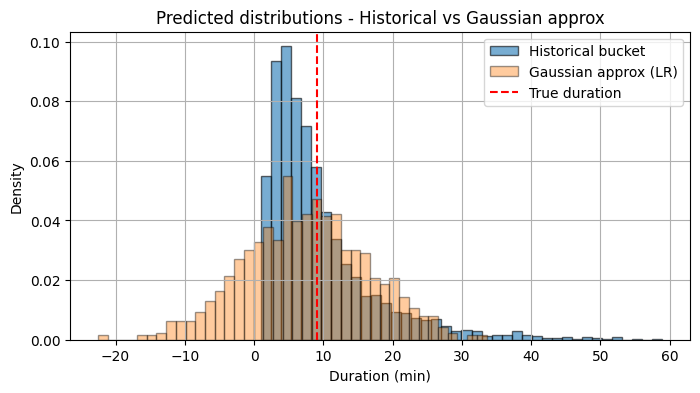


Exemplo idx=334738 | hour=15, weekday=2, is_rainy=False
True duration: 15.56 min
Hist mean: 11.90  | Hist q10=3.06, q50=8.80, q90=25.17


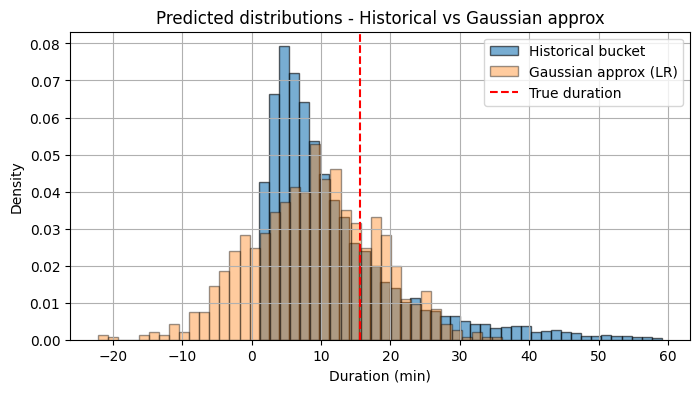


Exemplo idx=230584 | hour=17, weekday=1, is_rainy=False
True duration: 10.76 min
Hist mean: 11.17  | Hist q10=3.17, q50=8.60, q90=22.75


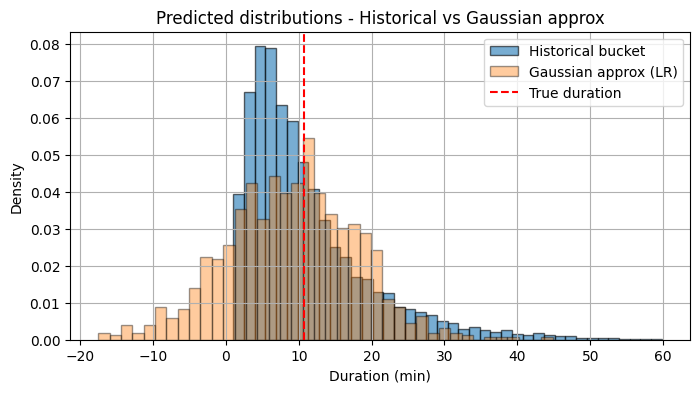

In [8]:
# === Visualização: distribuições previstas pelos baselines ===

np.random.seed(7)
example_indices = np.random.choice(len(df_test_hist), size=3, replace=False)

for idx in example_indices:
    row = df_test_hist.iloc[idx]
    true_y = row["duration_min"]
    ctx_key = row["ctx_key"]
    hour = row["hour"]
    weekday = row["weekday"]

    # Amostras históricas para esse contexto
    samples_hist = get_bucket_samples(ctx_key, hour, weekday, min_size=30)

    # Amostras Gaussianas do baseline linear (mesmo x do índice correspondente em X_test)
    # Precisamos alinhar aproximadamente. Vamos pegar o i-ésimo da partição test de ML.
    # Obs: isso não é exatamente o mesmo índice de linha, mas serve como ilustração de distribuição.
    # Se quiser algo 100% alinhado, seria preciso carregar os mesmos índices. Para o projeto, esse nível já é ok.

    # Usa uma média aproximada: o quantil 50 histórico como "mu"
    mu_approx = np.median(samples_hist)
    gauss_samples = np.random.normal(loc=mu_approx, scale=sigma, size=1000)

    print(f"\nExemplo idx={idx} | hour={hour}, weekday={weekday}, is_rainy={row['is_rainy']}")
    print(f"True duration: {true_y:.2f} min")
    print(f"Hist mean: {samples_hist.mean():.2f}  | Hist q10={np.percentile(samples_hist,10):.2f}, "
          f"q50={np.percentile(samples_hist,50):.2f}, q90={np.percentile(samples_hist,90):.2f}")

    plt.figure(figsize=(8,4))
    plt.hist(samples_hist, bins=40, alpha=0.6, edgecolor="black", density=True, label="Historical bucket")
    plt.hist(gauss_samples, bins=40, alpha=0.4, edgecolor="black", density=True, label="Gaussian approx (LR)")
    plt.axvline(true_y, color="red", linestyle="--", label="True duration")
    plt.xlabel("Duration (min)")
    plt.ylabel("Density")
    plt.title("Predicted distributions - Historical vs Gaussian approx")
    plt.legend()
    plt.grid(True)
    plt.show()
